In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('album.csv', 'albums'),
    ('artist.csv', 'artist'),
    ('customer.csv', 'customer'),
    ('employee.csv', 'employee'),
    ('genre.csv', 'genre'),
    ('invoice_line.csv', 'invoice_line'),  # Added payments.csv for specific handling
    ('invoice.csv', 'invoice'),
    ('media_type.csv', 'media_type'),
    ('playlist_track.csv', 'playlist_track'),
    ('playlist.csv', 'playlist'),
    ('track.csv', 'track')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='Rishabh@123',
    database='music'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:/sql project/music list project/music store data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector


db = mysql.connector.connect(host = "127.0.0.1",
                            username = "root",
                            password = "Rishabh@123",
                            database = "music")

cur = db.cursor()

### EASY QUESTIONS

Q1: Who is the senior most employee based on job title?

In [4]:
query = """ select first_name,last_name,title,levels from employee order by levels desc
limit 1 """

cur.execute(query)

data = cur.fetchall()

data

[('Mohan', 'Madan', 'Senior General Manager', 'L7')]

 Q2: Which countries have the most Invoices?

In [5]:
query = """
 SELECT count(*) as c , billing_country FROM music.invoice group by billing_country 
 order by c desc
 """

cur.execute(query)

data = cur.fetchall()

data

[(131, 'USA'),
 (76, 'Canada'),
 (61, 'Brazil'),
 (50, 'France'),
 (41, 'Germany'),
 (30, 'Czech Republic'),
 (29, 'Portugal'),
 (28, 'United Kingdom'),
 (21, 'India'),
 (13, 'Ireland'),
 (13, 'Chile'),
 (11, 'Finland'),
 (11, 'Spain'),
 (10, 'Poland'),
 (10, 'Denmark'),
 (10, 'Australia'),
 (10, 'Hungary'),
 (10, 'Sweden'),
 (10, 'Netherlands'),
 (9, 'Norway'),
 (9, 'Italy'),
 (9, 'Austria'),
 (7, 'Belgium'),
 (5, 'Argentina')]

In [6]:
df=pd.DataFrame(data,columns=["invoice_count","billing_country"])
df.head(10)

,invoice_count,billing_country
0,131,USA
1,76,Canada
2,61,Brazil
3,50,France
4,41,Germany
5,30,Czech Republic
6,29,Portugal
7,28,United Kingdom
8,21,India
9,13,Ireland


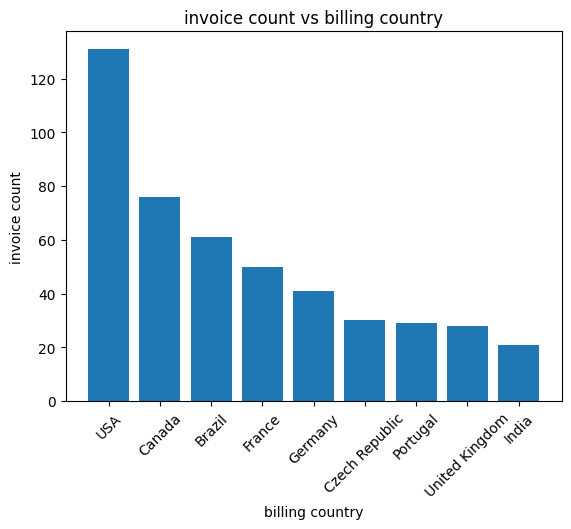

In [7]:
# Top 10

x=df['billing_country'][0:9]
y=df['invoice_count'][0:9]
plt.xlabel("billing country",fontsize=10)
plt.xticks(rotation=45)
plt.ylabel("invoice count",fontsize=10)
plt.title("invoice count vs billing country")
plt.bar(x,y)
plt.show()

Q3: What are top 3 values of total invoice?

In [8]:
query = """
 SELECT total FROM music.invoice  order by total desc limit 3;
 """

cur.execute(query)

data = cur.fetchall()

data

[(23.76,), (19.8,), (19.8,)]

Q4: Which city has the best customers? We would like to throw a promotional Music Festival in the city we made the most money. Write a query that returns one city that has the highest sum of invoice totals. Return both the city name & sum of all invoice totals

In [9]:
query = """
select billing_city , sum(total) as InvoiceTotal 
from invoice group by billing_city order by InvoiceTotal desc
limit 1 ; """

cur.execute(query)

data = cur.fetchall()

data

[('Prague', 273.2400002479553)]

In [10]:
# plot top 5 cities
query = """
select billing_city , sum(total) as InvoiceTotal 
from invoice group by billing_city order by InvoiceTotal desc
limit 5 ; """

cur.execute(query)

data = cur.fetchall()

data

[('Prague', 273.2400002479553),
 ('Mountain View', 169.29000115394592),
 ('London', 166.31999850273132),
 ('Berlin', 158.3999993801117),
 ('Paris', 151.4700005054474)]

In [11]:
df=pd.DataFrame(data , columns=["city","Total_invoice"])
df

,city,Total_invoice
0,Prague,273.240000
1,Mountain View,169.290001
2,London,166.319999
3,Berlin,158.399999
4,Paris,151.470001


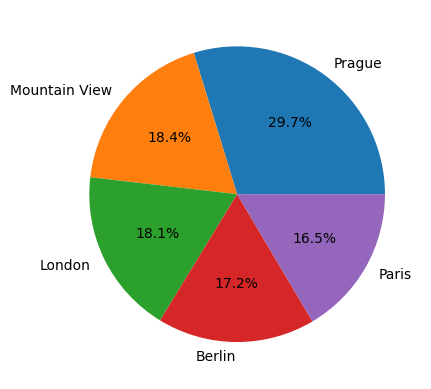

In [12]:
x=df['city']
y=df['Total_invoice']

plt.pie(y,labels=x,autopct="%0.1f%%")
plt.show()

Q5: Who is the best customer? The customer who has spent the most money will be declared the best customer. Write a query that returns the person who has spent the most money.

In [13]:
query = """
select customer.customer_id , customer.first_name, customer.last_name,
sum(invoice.total) as total from customer join invoice on
 customer.customer_id = invoice.customer_id
group by customer.customer_id ,customer.first_name,customer.last_name
order by total desc
limit 1 ;
 """

cur.execute(query)

data = cur.fetchall()

data

[(5, 'František', 'Wichterlová', 144.5399980545044)]

### MODERATE QUESTIONS

Q1: Write query to return the email, first name, last name, & Genre of all Rock Music listeners.Return your list ordered alphabetically by email starting with A.

In [14]:
query = """
select distinct customer.email , customer.first_name , customer.last_name from customer
join invoice on customer.customer_id = invoice.customer_id
join invoice_line on invoice.invoice_id = invoice_line.invoice_id
where track_id in (
   select track_id from track join genre on
   track.genre_id = genre.genre_id
   where genre.name like 'Rock'
)
order by email
;
 """

cur.execute(query)

data = cur.fetchall()

data

[('aaronmitchell@yahoo.ca', 'Aaron', 'Mitchell'),
 ('alero@uol.com.br', 'Alexandre', 'Rocha'),
 ('astrid.gruber@apple.at', 'Astrid', 'Gruber'),
 ('bjorn.hansen@yahoo.no', 'Bjørn', 'Hansen'),
 ('camille.bernard@yahoo.fr', 'Camille', 'Bernard'),
 ('daan_peeters@apple.be', 'Daan', 'Peeters'),
 ('diego.gutierrez@yahoo.ar', 'Diego', 'Gutiérrez'),
 ('dmiller@comcast.com', 'Dan', 'Miller'),
 ('dominiquelefebvre@gmail.com', 'Dominique', 'Lefebvre'),
 ('edfrancis@yachoo.ca', 'Edward', 'Francis'),
 ('eduardo@woodstock.com.br', 'Eduardo', 'Martins'),
 ('ellie.sullivan@shaw.ca', 'Ellie', 'Sullivan'),
 ('emma_jones@hotmail.com', 'Emma', 'Jones'),
 ('enrique_munoz@yahoo.es', 'Enrique', 'Muñoz'),
 ('fernadaramos4@uol.com.br', 'Fernanda', 'Ramos'),
 ('fharris@google.com', 'Frank', 'Harris'),
 ('fralston@gmail.com', 'Frank', 'Ralston'),
 ('frantisekw@jetbrains.com', 'František', 'Wichterlová'),
 ('ftremblay@gmail.com', 'François', 'Tremblay'),
 ('fzimmermann@yahoo.de', 'Fynn', 'Zimmermann'),
 ('hannah.

Q2: Let's invite the artists who have written the most rock music in our dataset. 
Write a query that returns the Artist name and total track count of the top 10 rock bands.

In [15]:
query = """
SELECT 
    artist.artist_id, 
    artist.name, 
    COUNT(track.track_id) AS number_of_songs 
FROM 
    artist 
JOIN 
    albums ON artist.artist_id = albums.artist_id 
JOIN 
    track ON albums.album_id = track.album_id 
JOIN 
    genre ON genre.genre_id = track.genre_id 
WHERE 
    genre.name LIKE 'Rock' 
GROUP BY 
    artist.artist_id, artist.name 
ORDER BY 
    number_of_songs DESC 
LIMIT 10;

 """

cur.execute(query)

data = cur.fetchall()

data

[(22, 'Led Zeppelin', 114),
 (150, 'U2', 112),
 (58, 'Deep Purple', 92),
 (90, 'Iron Maiden', 81),
 (118, 'Pearl Jam', 54),
 (152, 'Van Halen', 52),
 (51, 'Queen', 45),
 (142, 'The Rolling Stones', 41),
 (76, 'Creedence Clearwater Revival', 40),
 (52, 'Kiss', 35)]

Q3: Return all the track names that have a song length longer than the average song length. 
Return the Name and Milliseconds for each track. Order by the song length with the longest songs listed first.

In [16]:

query = """
select name ,milliseconds from track
where milliseconds > 
(select avg(milliseconds) from track)
order by milliseconds desc ;
 """

cur.execute(query)

data = cur.fetchall()

data

[('Occupation / Precipice', 5286953),
 ('Through a Looking Glass', 5088838),
 ('Greetings from Earth, Pt. 1', 2960293),
 ('The Man With Nine Lives', 2956998),
 ('Battlestar Galactica, Pt. 2', 2956081),
 ('Battlestar Galactica, Pt. 1', 2952702),
 ('Murder On the Rising Star', 2935894),
 ('Battlestar Galactica, Pt. 3', 2927802),
 ('Take the Celestra', 2927677),
 ('Fire In Space', 2926593),
 ('The Long Patrol', 2925008),
 ('The Magnificent Warriors', 2924716),
 ('The Living Legend, Pt. 1', 2924507),
 ('The Gun On Ice Planet Zero, Pt. 2', 2924341),
 ('The Hand of God', 2924007),
 ('Experiment In Terra', 2923548),
 ('War of the Gods, Pt. 2', 2923381),
 ('The Living Legend, Pt. 2', 2923298),
 ('War of the Gods, Pt. 1', 2922630),
 ('Lost Planet of the Gods, Pt. 1', 2922547),
 ("Baltar's Escape", 2922088),
 ('The Lost Warrior', 2920045),
 ('Lost Planet of the Gods, Pt. 2', 2914664),
 ('The Gun On Ice Planet Zero, Pt. 1', 2907615),
 ('Greetings from Earth, Pt. 2', 2903778),
 ('Crossroads, Pt. 2

### ADVANCE QUERY

1.  Find how much amount spent by each customer on artists? Write a query to return customer name, artist name and total spent

In [17]:
query = """

with best_selling_artist as(
select artist.artist_id as artist_id , artist.name as artist_name,
SUM(invoice_line.unit_price*invoice_line.quantity) as total_sales
from invoice_line
join track on track.track_id = invoice_line.track_id
join albums on albums.album_id = track.album_id
join artist on artist.artist_id = albums.artist_id
group by 1 , 2
order by 3 desc
limit 1
)

SELECT c.customer_id, c.first_name, c.last_name, bsa.artist_name,
round(SUM(il.unit_price*il.quantity),2) AS amount_spent
FROM invoice i
JOIN customer c ON c.customer_id = i.customer_id
JOIN invoice_line il ON il.invoice_id = i.invoice_id
JOIN track t ON t.track_id = il.track_id
JOIN albums alb ON alb.album_id = t.album_id
JOIN best_selling_artist bsa ON bsa.artist_id = alb.artist_id
GROUP BY 1,2,3,4
ORDER BY 5 DESC;

 """

cur.execute(query)

data = cur.fetchall()

data

[(46, 'Hugh', "O'Reilly", 'Queen', 27.72),
 (38, 'Niklas', 'Schröder', 'Queen', 18.81),
 (3, 'François', 'Tremblay', 'Queen', 17.82),
 (34, 'João', 'Fernandes', 'Queen', 16.83),
 (53, 'Phil', 'Hughes', 'Queen', 11.88),
 (41, 'Marc', 'Dubois', 'Queen', 11.88),
 (47, 'Lucas', 'Mancini', 'Queen', 10.89),
 (33, 'Ellie', 'Sullivan', 'Queen', 10.89),
 (20, 'Dan', 'Miller', 'Queen', 3.96),
 (5, 'František', 'Wichterlová', 'Queen', 3.96),
 (23, 'John', 'Gordon', 'Queen', 2.97),
 (31, 'Martha', 'Silk', 'Queen', 2.97),
 (54, 'Steve', 'Murray', 'Queen', 2.97),
 (8, 'Daan', 'Peeters', 'Queen', 1.98),
 (48, 'Johannes', 'Van der Berg', 'Queen', 1.98),
 (52, 'Emma', 'Jones', 'Queen', 1.98),
 (16, 'Frank', 'Harris', 'Queen', 1.98),
 (24, 'Frank', 'Ralston', 'Queen', 1.98),
 (11, 'Alexandre', 'Rocha', 'Queen', 1.98),
 (1, 'Luís', 'Gonçalves', 'Queen', 1.98),
 (35, 'Madalena', 'Sampaio', 'Queen', 1.98),
 (49, 'Stanisław', 'Wójcik', 'Queen', 1.98),
 (57, 'Luis', 'Rojas', 'Queen', 1.98),
 (28, 'Julia', 'B

Q2: We want to find out the most popular music Genre for each country. We determine the most popular genre as the genre with the highest amount of purchases. Write a query that returns each country along with the top Genre. For countries where the maximum number of purchases is shared return all Genres.

In [18]:
query = """

With popular_genre as(
select count(invoice_line.quantity) as purchase , customer.country , genre.name , genre.genre_id,
row_number() over(partition by customer.country order by count(invoice_line.quantity) desc) as rowno
from invoice_line 
join invoice on invoice.invoice_id = invoice_line.invoice_id
join customer on customer.customer_id = invoice.customer_id
join track on track.track_id = invoice_line.track_id
join genre on genre.genre_id = track.genre_id
group by 2 , 3 , 4
order by 2 asc , 1 desc
)
select * from popular_genre where rowno<=1;

 """

cur.execute(query)

data = cur.fetchall()

data

[(17, 'Argentina', 'Alternative & Punk', 4, 1),
 (34, 'Australia', 'Rock', 1, 1),
 (40, 'Austria', 'Rock', 1, 1),
 (26, 'Belgium', 'Rock', 1, 1),
 (205, 'Brazil', 'Rock', 1, 1),
 (333, 'Canada', 'Rock', 1, 1),
 (61, 'Chile', 'Rock', 1, 1),
 (143, 'Czech Republic', 'Rock', 1, 1),
 (24, 'Denmark', 'Rock', 1, 1),
 (46, 'Finland', 'Rock', 1, 1),
 (211, 'France', 'Rock', 1, 1),
 (194, 'Germany', 'Rock', 1, 1),
 (44, 'Hungary', 'Rock', 1, 1),
 (102, 'India', 'Rock', 1, 1),
 (72, 'Ireland', 'Rock', 1, 1),
 (35, 'Italy', 'Rock', 1, 1),
 (33, 'Netherlands', 'Rock', 1, 1),
 (40, 'Norway', 'Rock', 1, 1),
 (40, 'Poland', 'Rock', 1, 1),
 (108, 'Portugal', 'Rock', 1, 1),
 (46, 'Spain', 'Rock', 1, 1),
 (60, 'Sweden', 'Rock', 1, 1),
 (166, 'United Kingdom', 'Rock', 1, 1),
 (561, 'USA', 'Rock', 1, 1)]

3. Write a query that determines the customer that has spent the most on music for each country. Write a query that returns the country along with the top customer and how much they spent.For countries where the top amount spent is shared, provide all customers who spent this amount.

In [23]:
query = """

WITH Customter_with_country AS (
		SELECT customer.customer_id,first_name,last_name,billing_country,SUM(total) AS total_spending,
	    ROW_NUMBER() OVER(PARTITION BY billing_country ORDER BY SUM(total) DESC) AS RowNo 
		FROM invoice
		JOIN customer ON customer.customer_id = invoice.customer_id
		GROUP BY 1,2,3,4
		ORDER BY 4 ASC,5 DESC)
SELECT * FROM Customter_with_country WHERE RowNo <= 1


 """

cur.execute(query)

data = cur.fetchall()

data

[(56, 'Diego', 'Gutiérrez', 'Argentina', 39.59999918937683, 1),
 (55, 'Mark', 'Taylor', 'Australia', 81.18000030517578, 1),
 (7, 'Astrid', 'Gruber', 'Austria', 69.29999899864197, 1),
 (8, 'Daan', 'Peeters', 'Belgium', 60.389999866485596, 1),
 (1, 'Luís', 'Gonçalves', 'Brazil', 108.8999993801117, 1),
 (3, 'François', 'Tremblay', 'Canada', 99.98999810218811, 1),
 (57, 'Luis', 'Rojas', 'Chile', 97.01999974250793, 1),
 (5, 'František', 'Wichterlová', 'Czech Republic', 144.5399980545044, 1),
 (9, 'Kara', 'Nielsen', 'Denmark', 37.6199996471405, 1),
 (44, 'Terhi', 'Hämäläinen', 'Finland', 79.20000052452087, 1),
 (42, 'Wyatt', 'Girard', 'France', 99.98999905586243, 1),
 (37, 'Fynn', 'Zimmermann', 'Germany', 94.04999947547913, 1),
 (45, 'Ladislav', 'Kovács', 'Hungary', 78.2099997997284, 1),
 (58, 'Manoj', 'Pareek', 'India', 111.8699996471405, 1),
 (46, 'Hugh', "O'Reilly", 'Ireland', 114.83999943733215, 1),
 (47, 'Lucas', 'Mancini', 'Italy', 50.49000096321106, 1),
 (48, 'Johannes', 'Van der Berg